In [1]:
import re

import pandas as pd
from pathlib import Path
from ploting import *

In [15]:
root_path = "crusher"

In [16]:
name_re = re.compile("(weak|strong)_scaling-d_(\d+)-n_(\d+)-([\w_]+)_comm-(gpu|cpu)-nodes_(\d+)")

In [17]:
time_re = re.compile("DURATION:\s*(\d+(\.\d+)?(e[+-]\d+)?)")

In [18]:
data = []
for file in Path(f"{root_path}/data").iterdir():
    if m := name_re.search(file.name):
        with open(file, "r") as input:
            if t_m := time_re.search(input.read()):
                duration = t_m.group(1)
                data.append({"scaling": m.group(1), "dim": m.group(2), "n": m.group(3), "comm_pattern": m.group(4),
                             "type": m.group(5), "nodes": m.group(6), "time": duration})
df = pd.DataFrame(data).drop(columns=["scaling", "type"]).astype({"dim": int, "n": int, "nodes": int, "time": float})
df

,dim,n,comm_pattern,nodes,time
0,2,100,stencil,1,0.000027
1,2,100000,stencil,16,0.000067
2,2,100,stencil,128,0.000053
3,2,100000,stencil,128,0.000126
4,2,100,stencil,16,0.000037
...,...,...,...,...,...
152,3,1000000,optimal,2,0.000579
153,3,1000000,optimal,32,0.000580
154,3,1000000,optimal,4,0.000580
155,3,1000000,optimal,64,0.000581


In [19]:
piv = df.pivot(index="nodes", columns=["dim", "comm_pattern", "n"], values="time")
piv = piv[piv.columns.sort_values()]
piv

dim                  2                                                    \
comm_pattern   optimal                                           stencil   
n              100       1000      10000     100000    1000000   100       
nodes                                                                      
1             0.000024  0.000026  0.000033  0.000051  0.000280  0.000027   
2             0.000025  0.000027  0.000032  0.000050  0.000280  0.000030   
4             0.000027  0.000030  0.000033  0.000051  0.000281  0.000033   
8             0.000034  0.000031  0.000037  0.000050  0.000279  0.000039   
16            0.000035  0.000032  0.000037  0.000052  0.000281  0.000037   
32            0.000039  0.000033  0.000038  0.000051  0.000281  0.000039   
64            0.000046  0.000034  0.000039  0.000055  0.000282  0.000042   
128           0.000061  0.000037  0.000041  0.000057  0.000283  0.000053   

dim                                                          3            \
comm_pattern                                           optimal             
n              1000      10000     100000    1000000   100       1000      
nodes                                                                      
1             0.000032  0.000036  0.000055  0.000278  0.000026  0.000029   
2             0.000036  0.000041  0.000060  0.000280  0.000027  0.000029   
4             0.000038  0.000041  0.000060  0.000277  0.000029  0.000030   
8             0.000044  0.000051  0.000061  0.000279  0.000032  0.000033   
16            0.000045  0.000052  0.000067  0.000279  0.000033  0.000034   
32            0.000046  0.000054  0.000074  0.000285  0.000033  0.000035   
64            0.000051  0.000057  0.000089  0.000308  0.000035  0.000035   
128           0.000064  0.000092  0.000126       NaN  0.000037  0.000038   

dim                                                                       \
comm_pattern                                 stencil                       
n              10000     100000    1000000   100       1000      10000     
nodes                                                                      
1             0.000040  0.000076  0.000579  0.000032  0.000042  0.000064   
2             0.000040  0.000077  0.000579  0.000040  0.000048  0.000068   
4             0.000041  0.000077  0.000580  0.000048  0.000053  0.000072   
8             0.000044  0.000078  0.000580  0.000065  0.000069  0.000088   
16            0.000046  0.000080  0.000582  0.000068  0.000074  0.000093   
32            0.000046  0.000081  0.000580  0.000069  0.000074  0.000093   
64            0.000047  0.000083  0.000581  0.000084  0.000089  0.000103   
128           0.000050  0.000085  0.000583  0.000097  0.000104  0.000115   

dim                               
comm_pattern                      
n              100000    1000000  
nodes                             
1             0.000091  0.000637  
2             0.000098  0.000642  
4             0.000111  0.000656  
8             0.000138  0.000653  
16            0.000145  0.000649  
32            0.000157  0.000644  
64            0.000173       NaN  
128           0.000186       NaN

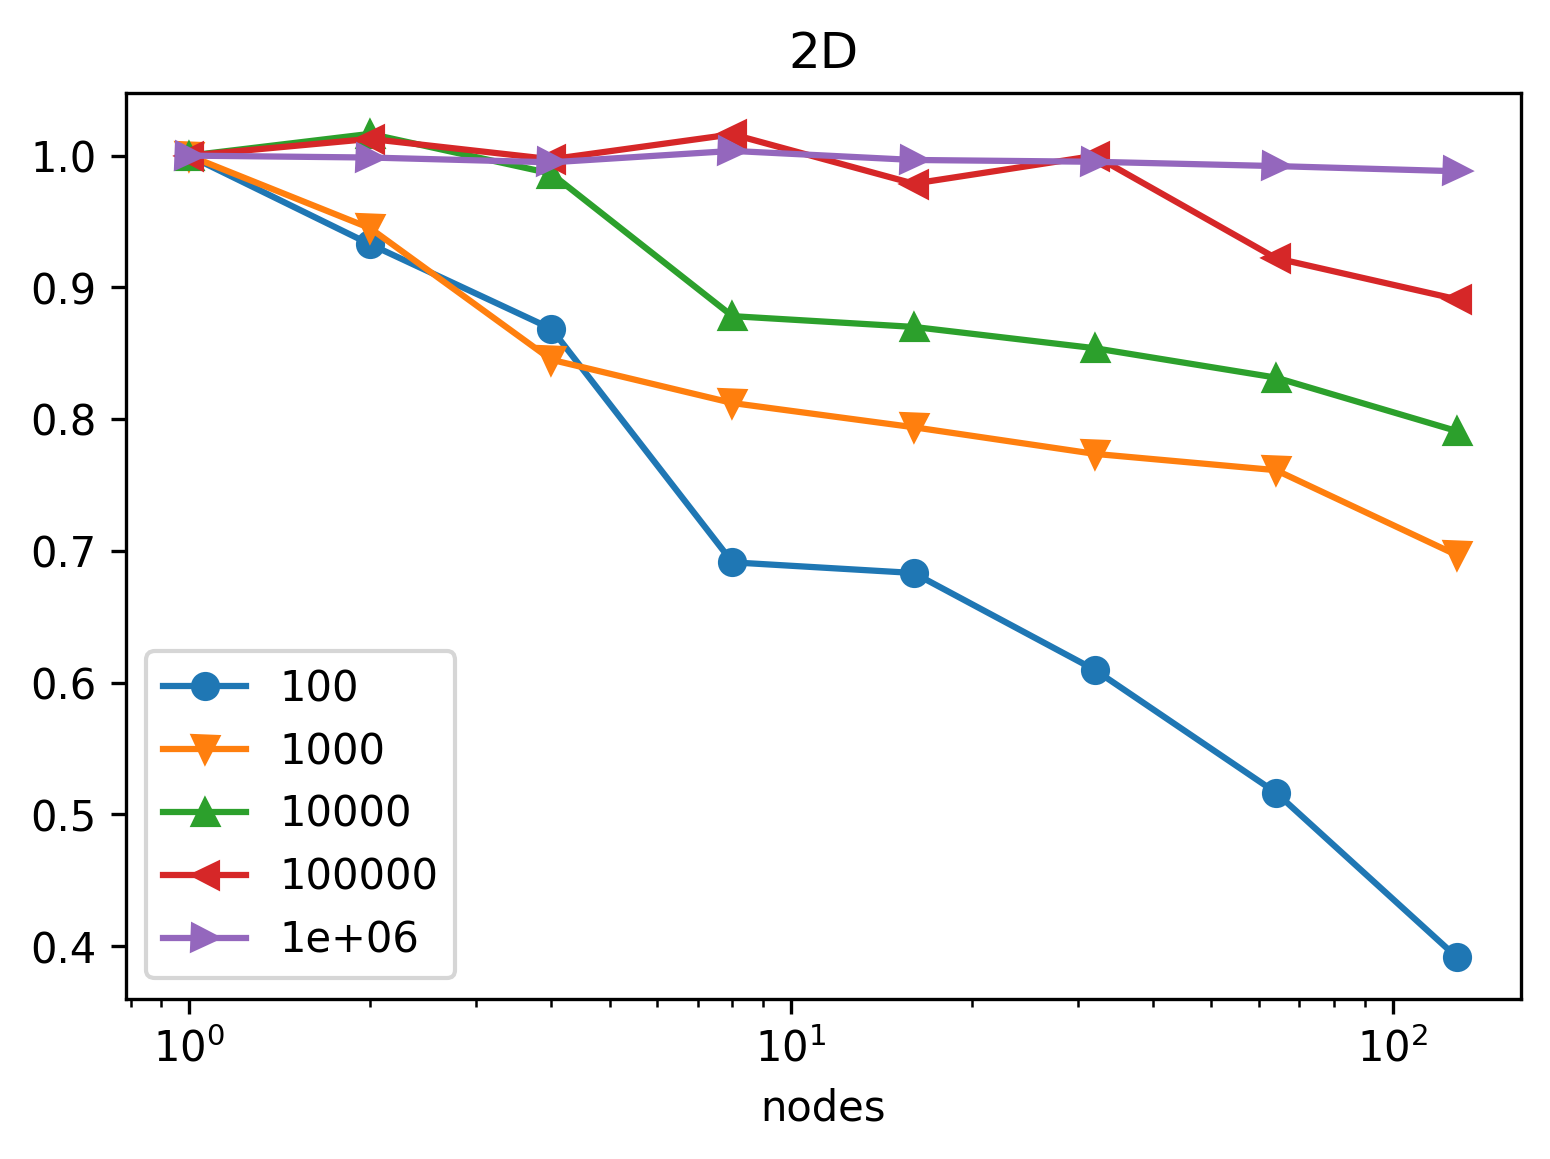

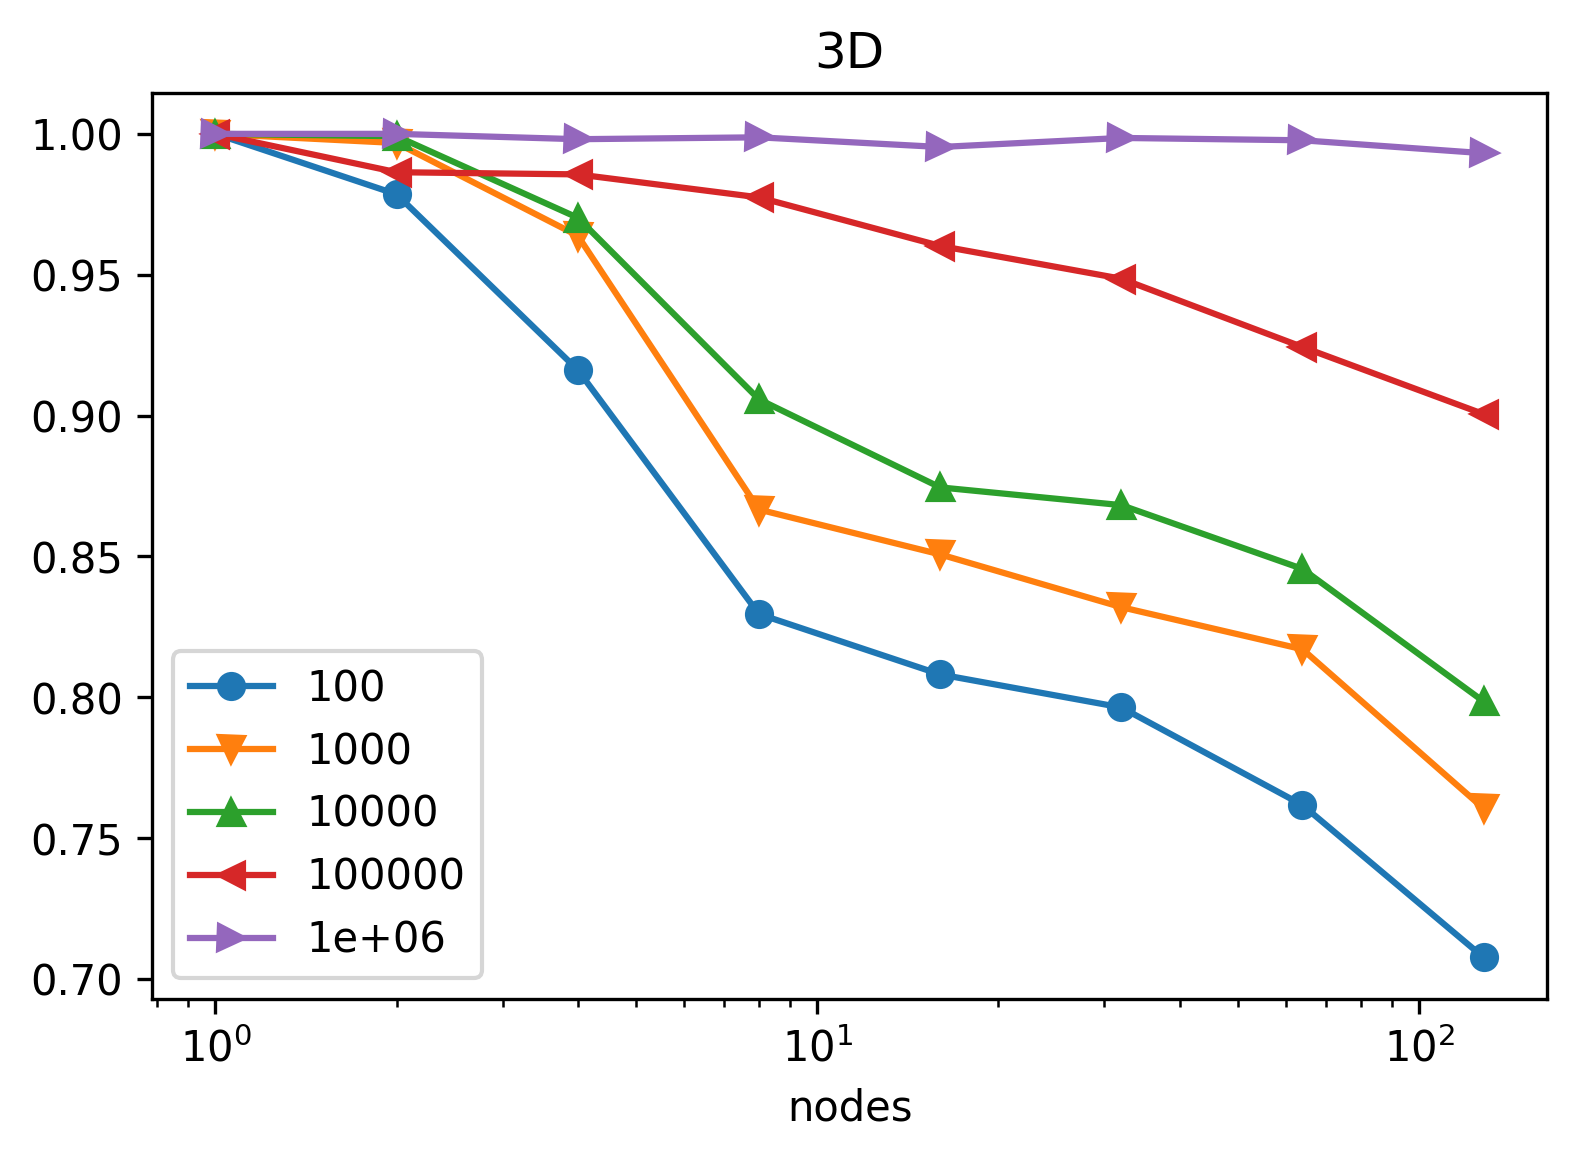

In [20]:
for dim in piv.columns.levels[0]:
    _df = piv[dim]
    fig, ax = plt.subplots(dpi=300)
    for gc in piv.columns.levels[1]:
        if gc == "optimal":
            ax.set_prop_cycle(default_cycler if gc == "optimal" else dashed_cylcer)
            ax.set_title(f"{dim}D")
            _df[gc].apply(lambda s: s[1] / s).plot(ax=ax, legend=False, logx=True)
            ax.legend([f"{n:g}" for n in piv.columns.levels[2]])
    fig.savefig(f"{root_path}/img/{dim}d.png")